<a href="https://colab.research.google.com/github/DanielFadlon/LWSM/blob/main/LWSM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **LWSM (Light-Weight Signature Matching)**
A framework for a resource limited service using PDS (Probabilistic Data Structure) and AI powered methods.

In [2]:
path2project = 'drive/MyDrive/AIForCyber/LWSM'
# Define a path to save the vectorized features (to prevent from creating them each time)
path2ember = f'{path2project}/ember2018'
# Define the given initial blacklist file path
path2malicous_sha256_ember = f'{path2project}/task1_malicous_sha256_ember.txt'

# data is the folder with the clean and prepared data
gdrive_data_folder = f'{path2project}/data1'
# fiures from notebook
gdrive_figures_folder = f'{path2project}/figures'

In [3]:
!pip install git+https://github.com/zivido/ember-3.9.git
!pip install lief
!pip install bitarray
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/zivido/ember-3.9.git to /tmp/pip-req-build-fsnv7e2k
  Running command git clone --filter=blob:none --quiet https://github.com/zivido/ember-3.9.git /tmp/pip-req-build-fsnv7e2k
  Resolved https://github.com/zivido/ember-3.9.git to commit bc8fe8fe990ed172c69320d13b757b384b8cc367
  Preparing metadata (setup.py) ... done
  Created wheel for ember: filename=ember-0.1.0-py3-none-any.whl size=13078 sha256=ae19e7500e22eca37411160cf94dbb1e473f4c46751c6a555d635a0e6ddf3fa6
  Stored in directory: /tmp/pip-ephem-wheel-cache-a1gcen7e/wheels/8a/de/4f/e2eadc2237ea0e00160b8a5b067e4e2d8ef94f361258d38dcf
Successfully built ember
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 91.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-

In [9]:
# Imports
import ember
import opendatasets as od
import tarfile
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import hashlib
import bitarray
from google.colab import drive
import shutil
import lightgbm as lgb
import altair as alt
import time
import pickle
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [5]:
# using drive
drive.mount('/content/drive') #, force_remount=True)

Mounted at /content/drive


In [6]:
def save_ember_vectorized_features(path: str):
  files_names = ['X_train.dat', 'y_train.dat', 'X_test.dat', 'y_test.dat', 'train_metadata.csv', 'test_metadata.csv', 'metadata.csv', 'ember_model_2018.txt']

  #imports dataset
  od.download("https://ember.elastic.co/ember_dataset_2018_2.tar.bz2") 

  tar = tarfile.open("./ember_dataset_2018_2.tar.bz2", "r:bz2")  
  #unzips and decompresses dataset
  tar.extractall() 
  tar.close()

  data_dir = "./ember2018"
  ember.create_vectorized_features(data_dir)
  _ = ember.create_metadata(data_dir)


  # Copy the file from local storage to Google Drive
  for file_name in files_names:
    shutil.copy(f'./ember2018/{file_name}', f'{path}/{file_name}')

## **Dataset Management - EMBER2018**

In this section, we thoroughly inspect, preprocess, and explore the EMBER2018 dataset, an extensive corpus of executable metadata crucial for cybersecurity applications. Our methodology can be broken down into the following steps:

1. **Dataset Description** 

2. **Data Cleaning and Preparation** 

3. **Dimensionality Reduction** 

4. **Variance Visualization** 

5. **Exploratory Data Analysis (EDA)** 

6. **Dimension Decision** 

7. **Summary and Next Steps** 

By following this thorough approach to dataset management, we ensure that the EMBER2018 dataset is meticulously inspected, cleaned, prepared, and understood, facilitating effective and informed model development in the subsequent stages of our project.

### Load The Data

In [7]:
# Check if the vectorized features have already been saved
try:
  X_train, y_train, X_test, y_test = ember.read_vectorized_features(path2ember)
  emberdf = ember.read_metadata(path2ember)
  lgbm_model = lgb.Booster(model_file=f'{path2ember}/ember_model_2018.txt')
  print('datasets, dataframe and model are loded successfuly')
except FileNotFoundError:
  # If the file doesn't exist, create the vectorized features and save them
  print('Start to create vaetorized fetures')
  save_ember_vectorized_features(path2ember)
  print('Created and saved vectorized features to path')
  print('Check that your files are copied to the required dirctory and execute this cell again')

datasets, dataframe and model are loded successfuly


### Data Description

In [7]:
emberdf.head()

,sha256,appeared,label,avclass,subset
0,0abb4fda7d5b13801d63bee53e5e256be43e141faa077a...,2006-12,0,NaN,train
1,c9cafff8a596ba8a80bafb4ba8ae6f2ef3329d95b85f15...,2007-01,0,NaN,train
2,eac8ddb4970f8af985742973d6f0e06902d42a3684d791...,2007-02,0,NaN,train
3,7f513818bcc276c531af2e641c597744da807e21cc1160...,2007-02,0,NaN,train
4,ca65e1c387a4cc9e7d8a8ce12bf1bcf9f534c9032b9d95...,2007-02,0,NaN,train


In [8]:
# Constants Colors
red_malicous = '#ff3333'
blue_benign = '#3333ff'
green_unlabled = '#00b300'

In [9]:
plotdf = emberdf.copy()
gbdf = plotdf.groupby(["label", "subset"]).count().reset_index()
alt.Chart(gbdf).mark_bar().encode(
    alt.X('subset:O', axis=alt.Axis(title='Subset')),
    alt.Y('sum(sha256):Q', axis=alt.Axis(title='Number of samples')),
    alt.Color('label:N', scale=alt.Scale(range=[green_unlabled, blue_benign, red_malicous]), legend=alt.Legend(values=["unlabeled", "benign", "malicious"]))
)

alt.Chart(...)

In [10]:
plotdf = emberdf.copy()
plotdf.loc[plotdf["appeared"] < "2018-01", "appeared"] = " <2018"
gbdf = plotdf.groupby(["appeared", "label"]).count().reset_index()
alt.Chart(gbdf).mark_bar().encode(
    alt.X('appeared:O', axis=alt.Axis(title='Month appeared')),
    alt.Y('sum(sha256):Q', axis=alt.Axis(title='Number of samples')),
    alt.Color('label:N', scale=alt.Scale(range=[green_unlabled, blue_benign, red_malicous]), legend=alt.Legend(values=["unlabeled", "benign", "malicious"]))
)

alt.Chart(...)

Observing the above, data is separated in an odd way, since in the real world that your company exists in, there aren't 50%  of malicous files (from the labeled files)

In [15]:
# Number of features
print('Number of features:', X_train.shape[1])

Number of features: 2381


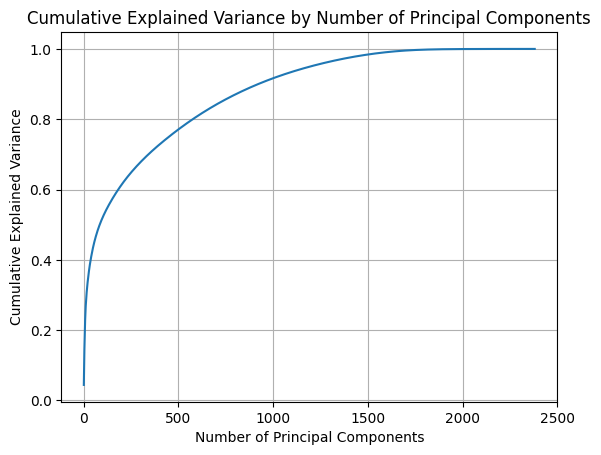

In [16]:
# Standardizing the features to have mean=0 and variance=1
X_norm = StandardScaler().fit_transform(X_train)

# Create an instance of PCA
f_pca = PCA()

# Fit PCA on your dataset
f_pca.fit(X_norm)

# Transform the dataset using the fitted PCA
X_full_pca = f_pca.transform(X_norm)

# Access the explained variance ratio
explained_variance_ratio = f_pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)


plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_explained_variance)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Number of Principal Components')
plt.grid(True)
plt.savefig('cumulative_explained_variance_by_number_of_pcs.png')
plt.show()

### Data Cleaning and Preparation by Statistics Characteristics

In [9]:
def remove_unlabled_samples(X, y):
  """
    Remove unlabeled samples.
    Unlabled smaple has value = -1.
  """
  labelled_indices = np.where(y_train != -1)

  X_labelled = X[labelled_indices]
  y_labelled = y[labelled_indices]

  return X_labelled, y_labelled

def remove_low_variance_features(X, threshold=0.01):
  """
    Remove features with standard deviation less than the specified threshold.
  """
  # Compute standard deviations of each feature
  stds = np.std(X, axis=0)

  # Get the indices of features with standard deviation greater than or equal to the threshold
  high_variance_feature_indices = np.where(stds >= threshold)[0]

  # Extract high variance features
  X_high_variance = X[:, high_variance_feature_indices]

  return X_high_variance


def _calculate_number_of_chunks(num_samples, chunk_size):
  n_chunks = num_samples // chunk_size
  raw_chunks = num_samples / chunk_size

  return n_chunks if n_chunks >= raw_chunks else n_chunks + 1


def remove_features_with_low_correlation_to_target(X, y, threshold= 0.005, chunk_size=200000):
  """
    Removes features from X that have low correlation to target y.
  """
  def _get_correlations_df(X, y, threshold= 0.005, chunk_size=200000, return_remaining_features = False):
    
    # Calculate the number of chunks
    n_chunks = _calculate_number_of_chunks(X.shape[0], chunk_size)

    # Initialize an empty DataFrame to store correlations
    correlations = pd.DataFrame(index=range(X.shape[1]), columns=["pearson"])

    # Loop through the data in chunks
    for i in range(n_chunks):
      start = i * chunk_size
      end = start + chunk_size

      # Load a chunk into memory
      X_chunk = X[start:end, :]
      y_chunk = y[start:end]

      # Calculate Pearson correlation for each feature in the chunk
      for feature in range(X_chunk.shape[1]):
        corr, _ = pearsonr(X_chunk[:, feature], y_chunk)
        if i == 0:
            correlations.loc[feature, "pearson"] = corr
        else:
          correlations.loc[feature, "pearson"] = (correlations.loc[feature, "pearson"] * i + corr) / (i + 1)
    return correlations

  correlations = _get_correlations_df(X, y, threshold= 0.005, chunk_size=200000)

  # Drop features with correlation less than thershold  
  remaining_features =  correlations["pearson"].abs() >= threshold
  correlations = correlations[remaining_features]
  remaining_features = correlations.index.values

  return X[:, remaining_features]


def get_features_correlation(X, chunk_size=200000):
  """
     Removes one feature of every pair of features with a correlation greater than the threshold.
  """

  # Calculate the number of chunks
  n_chunks = _calculate_number_of_chunks(X.shape[0], chunk_size)

  # Initialize an empty DataFrame to store feature-feature correlations
  feature_correlations = pd.DataFrame(index=range(X.shape[1]), columns=range(X.shape[1]))

  # Loop through the data in chunks
  for i in range(n_chunks):
    start = i * chunk_size
    end = start + chunk_size

    # Load a chunk into memory
    X_chunk = X[start:end, :]

    # Calculate Pearson correlation for each feature with other features
    for feature1 in range(X_chunk.shape[1]):
      for feature2 in range(feature1+1, X_chunk.shape[1]):
        corr, _ = pearsonr(X_chunk[:, feature1], X_chunk[:, feature2])
        if i == 0:
            feature_correlations.loc[feature1, feature2] = corr
        else:
            feature_correlations.loc[feature1, feature2] = (feature_correlations.loc[feature1, feature2] * i + corr) / (i + 1)

  return feature_correlations

def remove_highly_correlated(X, corr_features, threshold):
  remaining_features = [True for _ in range(X.shape[1])]

  for feature in range(corr_features.shape[0]):
    if any(corr_features.loc[feature] > threshold):
      # Drop
      remaining_features[feature] = False
  return X[:, remaining_features]

In [10]:
print(X_train.shape)
# Remove unlabeled samples
X_train, y_train = remove_unlabled_samples(X_train, y_train)
print(X_train.shape)
# Remove low variance features
X_train = remove_low_variance_features(X_train)
print(X_train.shape)
# Calculate Pearson correlation for each feature with the target
X_train = remove_features_with_low_correlation_to_target(X_train, y_train)
print(X_train.shape)

(800000, 2381)
(600000, 2381)
(600000, 1822)
(600000, 1461)


In [11]:
corr_features = pd.read_csv(f'{gdrive_data_folder}/corr_features.csv')

In [24]:
corr_features = get_features_correlation(X_train)

In [12]:
X_train_wo_colinear = remove_highly_correlated(X_train, corr_features, 0.7)

In [13]:
X_train_wo_colinear.shape

(600000, 1356)

In [ ]:
# Split the training set to train and validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=42)
print(f'X_train: {X_train.shape}')
print(f'X_val: {X_val.shape}')

X_train: (480000, 1461)
X_val: (120000, 1461)


### EDA - Exploratory Data Analysis

Finding the right dimension involves balancing information retention and computational efficiency, utilizing techniques like PCA and evaluating the cumulative explained variance, and considering the specific characteristics and requirements for the dataset and task.

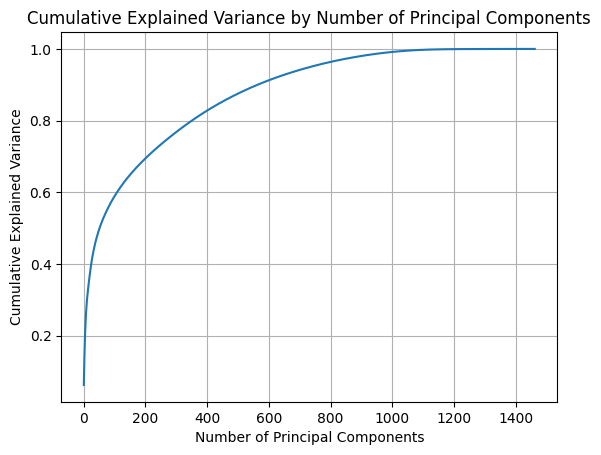

In [ ]:
# Standardizing the features to have mean=0 and variance=1
X_train_norm = StandardScaler().fit_transform(X_train)

# Create an instance of PCA
pca = PCA()

# Fit PCA on your dataset
pca.fit(X_train_norm)

# Transform the dataset using the fitted PCA
X_pca = pca.transform(X_train_norm)

# Access the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)


plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_explained_variance)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Number of Principal Components')
plt.grid(True)
plt.savefig('cumulative_explained_variance_by_number_of_pcs.png')
plt.show()

In [ ]:
print(f'Cumulative Explained Variance for 600 Principal Components: {cumulative_explained_variance[600]}')
print(f'Cumulative Explained Variance for 700 Principal Components: {cumulative_explained_variance[700]}')

Upon examining the cumulative variance across our principal components, it becomes evident that approximately 700 components account for roughly 95% of the total variance within our dataset. This significant proportion of explained variance solidifies the choice of these 700 dimensions as the optimal balance between preserving data integrity and maintaining computational efficiency.

In [ ]:
n_components = 700

In [ ]:
# Save 'X_pca', the reduced-dimension representation of the input data.
pca = PCA(n_components=n_components, random_state=42)
X_pca = pca.fit_transform(X_train_norm)

In [ ]:
def visualize(X, y, title, labels = ['x', 'y'], file_name='figure', to_save=True, grid=True, i=0, j=1):
  plt.scatter(X[y==0, i], X[y==0, j], alpha=0.5, label='Benign', s=2)
  plt.scatter(X[y==1, i], X[y==1, j], alpha=0.5, label='Malicious', s=2)
  plt.legend()
  plt.title(title)
  plt.xlabel(labels[0])
  plt.ylabel(labels[1])
  plt.grid(grid)
  plt.show()
  if to_save:
    plt.savefig(f'{file_name}.png')

Principal Component Analysis (PCA) Scatter Plot for Malicious and Benign Files

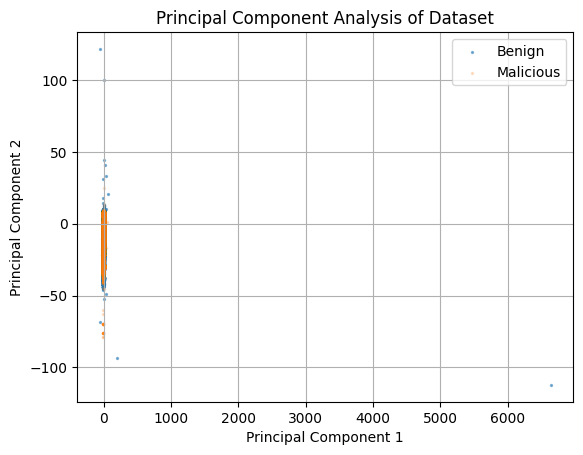

<Figure size 640x480 with 0 Axes>

In [ ]:
visualize(
    X=X_pca,
    y=y_train,
    title='Principal Component Analysis of Dataset',
    labels = ['Principal Component 1', 'Principal Component 2'],
    file_name = 'pca_0_to_1'
)

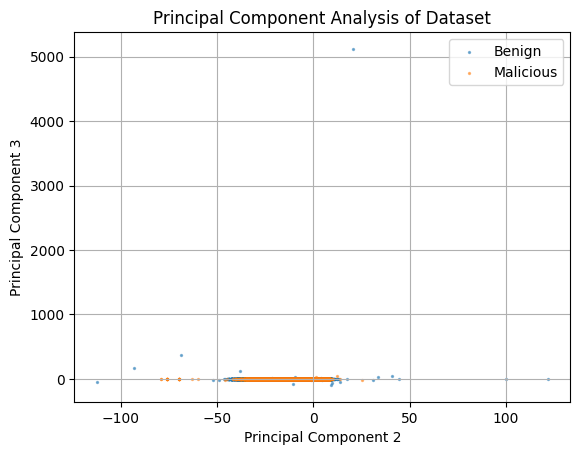

In [ ]:
visualize(
    X=X_pca,
    y=y_train,
    title='Principal Component Analysis of Dataset',
    labels = ['Principal Component 2', 'Principal Component 3'],
    i=1,
    j=2,
)

#### t-SNE Visualization of Malicious and Benign Files

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


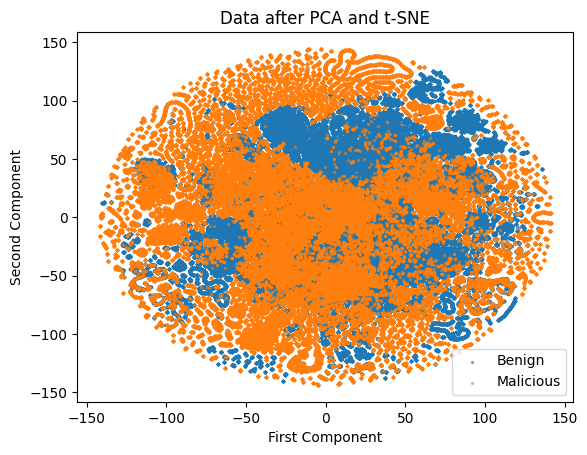

<Figure size 640x480 with 0 Axes>

In [ ]:
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X_pca)

visualize(
    X=X_tsne,
    y=y_train,
    title='Data after PCA and t-SNE',
    labels = ['First Component', 'Second Component'],
    file_name = 'tNSE'
)

## **Models**

Harnessing the power of XGBoost, a gradient-boosted decision tree model, acclaimed for its adeptness at handling high-dimensional data. The rationale behind this choice is its proven track record of high performance, and the inherent efficiency and optimization of the algorithm.

In [17]:
def print_result(y_true, y_pred, title):
  print(f'{title}:')
  print()


  # Compute accuracy
  accuracy = accuracy_score(y_true, y_pred)
  print("Accuracy: ", accuracy)

  # Compute confusion matrix
  tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

  # Compute false positive rate (FPR) and true positive rate (TPR)
  fpr = fp / (fp + tn)
  tpr = tp / (tp + fn)

  print("False Positive Rate (FPR): ", fpr)
  print("True Positive Rate (TPR): ", tpr)


  # Compute false negative rate (FNR) and true negative rate (TNR)
  fnr = fn / (fn + tp)
  tnr = tn / (tn + fp)

  print("False Negative Rate (FNR): ", fnr)
  print("True Negative Rate (TNR): ", tnr)

  
def classify_by_threshold(y_pred_cont, threshold=0.5):
  y_pred = [1 if score > threshold else 0 for score in y_pred_cont]
  return y_pred

## Evaluation Metrics

In [19]:
def _get_threshold_by_fpr(thresholds, fpr, target_fpr=0.001):
  # Find the threshold for the FPR closest to the target FPR
  idx = np.argmin(np.abs(fpr - target_fpr))
  threshold_at_target_fpr = thresholds[idx]
  print(f'The threshold that corresponds to FPR={target_fpr} is {threshold_at_target_fpr:.3f}')
  return threshold_at_target_fpr


def _plot_curve(fpr, tpr, label):
  plt.figure()
  plt.plot(fpr, tpr, label=label)
  plt.xlim([0.0, 0.006])
  plt.ylim([0.0, 1.05])
  plt.grid(True)
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic Curve')
  plt.legend(loc="lower right")

  # Customizations
  plt.xticks([0, 0.001, 0.003, 0.006])  # Set x-axis ticks
  # Find the y-value corresponding to x=0.001
  y_at_x = np.interp(0.001, fpr, tpr)

  # Draw a horizontal line at the corresponding y-value for x=0.001
  plt.axhline(y=y_at_x, color='g', linestyle='--')
  plt.axvline(x=0.001, color='g', linestyle='--')  # Draw vertical line at x=0.001

  # Show the plot
  plt.show()


def roc_curve_results(y_true, y_pred_prob, label= 'XGBoost Model', target_fpr=0.001):
  """
    Plot the ROC curve. 

    Returns the threshold for the traget fpr
  """
  fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
  threshold_at_target_fpr = _get_threshold_by_fpr(thresholds, fpr, target_fpr)
  _plot_curve(fpr, tpr, label=f'{label}. \n ROC accuracy scrore: {roc_auc_score(y_true, y_pred_prob):.3f}.')

  return threshold_at_target_fpr


def benign_results_on_threshold(y_true, y_pred_prob, threshold, label= 'XGBoost Model'):
  """
    Plot the ROC curve. 

    Returns the threshold for the traget fpr
  """
  # Classify by threshold
  y_pred = [1 if score > threshold else 0 for score in y_pred_prob]
  # Compute confusion matrix
  tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
  # Compute false negative rate (FNR) and true negative rate (TNR)
  fnr = fn / (fn + tp)
  tnr = tn / (tn + fp)

  print(f'{label}: (th={threshold})')
  print()
  print("False Negative Rate (FNR): ", fnr)
  print("True Negative Rate (TNR): ", tnr)


## **Model 1**



In [19]:
X_train = np.load(f'{gdrive_data_folder}/X_train.npy')
y_train = np.load(f'{gdrive_data_folder}/y_train.npy')
X_val = np.load(f'{gdrive_data_folder}/X_val.npy')
y_val = np.load(f'{gdrive_data_folder}/y_val.npy')

In [20]:
X_train.shape

(480000, 1461)

In [21]:
# Convert the data into DMatrix format for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_val, label=y_val) # y_test

# Set the parameters for the xgboost
param = {
    'max_depth': 6,  # maximum depth of each tree
    'eta': 0.3,  # learning_rate
    'objective': 'binary:logistic',  
    'num_class': 1 
} 
num_round = 800  # the number of training iterations

# Train the model
model_1 = xgb.train(param, dtrain, num_round, early_stopping_rounds=10, evals=[(dtest, 'test')])

# Make predictions
preds = model_1.predict(dtest)

[0]	test-logloss:0.54955
[1]	test-logloss:0.45893
[2]	test-logloss:0.40377
[3]	test-logloss:0.36220
[4]	test-logloss:0.33045
[5]	test-logloss:0.30378
[6]	test-logloss:0.28193
[7]	test-logloss:0.26004
[8]	test-logloss:0.24737
[9]	test-logloss:0.23401
[10]	test-logloss:0.22673
[11]	test-logloss:0.21963
[12]	test-logloss:0.21352
[13]	test-logloss:0.20634
[14]	test-logloss:0.19792
[15]	test-logloss:0.19131
[16]	test-logloss:0.18788
[17]	test-logloss:0.18478
[18]	test-logloss:0.17972
[19]	test-logloss:0.17483
[20]	test-logloss:0.17242
[21]	test-logloss:0.16986
[22]	test-logloss:0.16737
[23]	test-logloss:0.16490
[24]	test-logloss:0.16329
[25]	test-logloss:0.16160
[26]	test-logloss:0.15844
[27]	test-logloss:0.15533
[28]	test-logloss:0.15106
[29]	test-logloss:0.15020
[30]	test-logloss:0.14879
[31]	test-logloss:0.14714
[32]	test-logloss:0.14526
[33]	test-logloss:0.14367
[34]	test-logloss:0.14206
[35]	test-logloss:0.13976
[36]	test-logloss:0.13880
[37]	test-logloss:0.13824
[38]	test-logloss:0.13

In [45]:
# save model
with open(f'{gdrive_figures_folder}/extractedModel.pkl', 'wb') as f:
    pickle.dump(model_1, f)

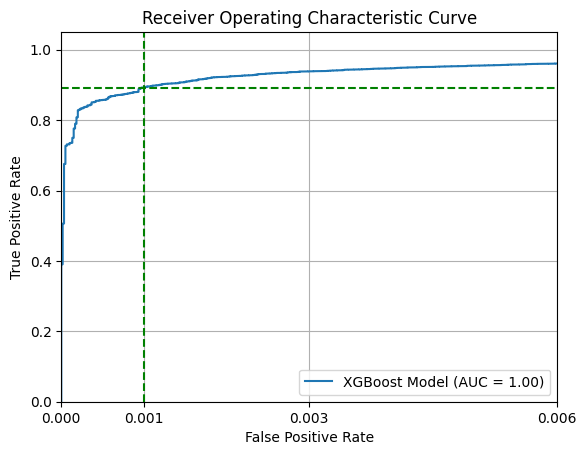

In [66]:
 plot_roc_curve(fpr, tpr, "", y_val, preds)

In [10]:
with open(f'{gdrive_figures_folder}/extractedModel.pkl', 'rb') as f:
    model_1 = pickle.load(f)

In [50]:
y_pred_98 = classify_by_threshold(preds, 0.98) 
print_result(y_true=y_val, y_pred=y_pred_98, title='98% threshold results')

98% threshold results:

Accuracy:  0.9456166666666667
False Positive Rate (FPR):  0.0009678119107610672
True Positive Rate (TPR):  0.8923274125618018
False Negative Rate (FNR):  0.10767258743819813
True Negative Rate (TNR):  0.9990321880892389


Find the model with the best parameters

In [ ]:
# Instantiate the XGBoost classifier object with GPU support
xgb_clf = xgb.XGBClassifier(objective='binary:logistic', num_class=1, tree_method='gpu_hist')

# Define the parameter grid
param_grid = {
    'max_depth': [3, 4, 5, 6, 7],  
    'learning_rate': [0.2, 0.3, 0.4],  
    'n_estimators': [200, 400, 600, 800, 1000]
}

# Create a GridSearchCV object with roc_auc as the scoring metric
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None, num_class=1,
                                     num_parallel_tree=None, predictor=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.2, 0.3, 0.4],
                         'max_depth': [3, 4, 5, 6, 7],
                         'n_estimators': [200, 400, 600, 800, 1000]},
             scoring='roc_auc')

In [ ]:
# Get the best model
best_model = grid_search.best_estimator_

# Predict using the best model and the test dataset
y_pred = best_model.predict(X_test)

# Print the predictions
# print("Predictions: ", y_pred)

In [ ]:
y_pred_50 = classify_by_threshold(y_pred, 0.5)
print_result(y_true=y_test, y_pred=y_pred_50, title='50% threshold results')

y_pred_85 = classify_by_threshold(y_pred, 0.85) 
print_result(y_true=y_test, y_pred=y_pred_85, title='85% threshold results')

50% threshold results:

Accuracy:  0.9842
False Positive Rate (FPR):  0.014283568889852993
True Positive Rate (TPR):  0.9826871535349836
85% threshold results:

Accuracy:  0.9842
False Positive Rate (FPR):  0.014283568889852993
True Positive Rate (TPR):  0.9826871535349836


## **Model 2**

In [67]:
n_components = 700
X_train_norm = StandardScaler().fit_transform(X_train)
# Save 'X_pca', the reduced-dimension representation of the input data.
pca = PCA(n_components=n_components, random_state=42)
X_train_pca = pca.fit_transform(X_train_norm)

In [68]:
X_val_norm = StandardScaler().fit_transform(X_val)
# Apply PCA transformation on the test data
X_val_pca = pca.transform(X_val_norm)

In [69]:
# Convert the data into DMatrix format for XGBoost
dtrain = xgb.DMatrix(X_train_pca, label=y_train)
dtest = xgb.DMatrix(X_val_pca, label=y_val) # y_test

# Set the parameters for the xgboost
param = {
    'max_depth': 6,  # maximum depth of each tree - try increasing this to 6 or 7
    'eta': 0.3,  # the training step for each iteration (alias: learning_rate)
    'objective': 'binary:logistic',  # error evaluation for multiclass training 
    'num_class': 1  # the number of classes that exist in this datset
} 
num_round = 800  # the number of training iterations

# Train the model
model_2 = xgb.train(param, dtrain, num_round, early_stopping_rounds=10, evals=[(dtest, 'test')])

# Make predictions
preds = model_2.predict(dtest)

[0]	test-logloss:0.57473
[1]	test-logloss:0.50136
[2]	test-logloss:0.45637
[3]	test-logloss:0.41763
[4]	test-logloss:0.38752
[5]	test-logloss:0.36723
[6]	test-logloss:0.35305
[7]	test-logloss:0.34157
[8]	test-logloss:0.32790
[9]	test-logloss:0.31816
[10]	test-logloss:0.30794
[11]	test-logloss:0.30086
[12]	test-logloss:0.29364
[13]	test-logloss:0.28789
[14]	test-logloss:0.28357
[15]	test-logloss:0.27800
[16]	test-logloss:0.27446
[17]	test-logloss:0.27081
[18]	test-logloss:0.26570
[19]	test-logloss:0.26116
[20]	test-logloss:0.25822
[21]	test-logloss:0.25467
[22]	test-logloss:0.25018
[23]	test-logloss:0.24712
[24]	test-logloss:0.24465
[25]	test-logloss:0.24317
[26]	test-logloss:0.24171
[27]	test-logloss:0.23842
[28]	test-logloss:0.23503
[29]	test-logloss:0.23344
[30]	test-logloss:0.23130
[31]	test-logloss:0.22876
[32]	test-logloss:0.22657
[33]	test-logloss:0.22545
[34]	test-logloss:0.22378
[35]	test-logloss:0.22226
[36]	test-logloss:0.22046
[37]	test-logloss:0.21903
[38]	test-logloss:0.21

In [70]:
# save model
with open(f'{gdrive_figures_folder}/pcaModel.pkl', 'wb') as f:
    pickle.dump(model_2, f)

In [71]:
pca_th = get_threshold_by_fpr(thresholds, fpr)

The threshold that corresponds to FPR=0.001 is 0.980


In [72]:
y_pred_th = classify_by_threshold(preds, pca_th) 
print_result(y_true=y_val, y_pred=y_pred_th, title= 'threshold results')

threshold results:

Accuracy:  0.7856583333333333
False Positive Rate (FPR):  0.0007508885514525521
True Positive Rate (TPR):  0.5725724559271529
False Negative Rate (FNR):  0.4274275440728471
True Negative Rate (TNR):  0.9992491114485474


In [21]:
with open(f'{gdrive_figures_folder}/pcaModel.pkl', 'rb') as f:
    model_2 = pickle.load(f)

## **~Model 3**

### Evaluating Performance on Realistic Class Separation ###

In this section, we aim to evaluate the performance of our model on datasets that simulate real-world class distributions, as they are often not evenly split (50/50). By considering class separations that are more representative of real-world scenarios, we can gain insights into how our model performs in practical settings.

To achieve this, we create datasets with unequal class proportions, such as 20/80 or 10/90 splits, to mimic imbalanced class distributions commonly encountered in real-world data.

We explore alternative data separation strategies or consider using different models that can be trained on similar data proportions. By doing so, we aim to uncover approaches that are better suited for real-world conditions and have the potential to enhance the model's predictive capabilities.

Interestingly, during our experimentation, we observed that the model exhibits robustness and consistently delivers improved results when the data separation is aligned with real-world scenarios.


In [14]:
X_val = np.load(f'{gdrive_data_folder}/X_val.npy')
y_val = np.load(f'{gdrive_data_folder}/y_val.npy')

In [20]:
def _print_separation_proportion(y_adjusted):
  _, (num_benigns, num_malicious) = np.unique(y_adjusted, return_counts = True)
  num_samples = num_malicious + num_benigns
  proportion = num_malicious / num_samples
  print(f'#samples: {num_samples}')
  print(f'#benign: {num_benigns}')
  print(f'#malicious: {num_malicious}')
  print(f'proportion: {proportion:.3f}')

def separate_val_data(X, y, malicious_proportion):
  malicous_val_indices = np.where(y == 1)[0]
  num_malicous_val_adjusted = int(malicious_proportion * len(malicous_val_indices))
  selected_malicous_indices = np.random.choice(malicous_val_indices, size=num_malicous_val_adjusted, replace=False)

  X_adjusted = np.concatenate((X[selected_malicous_indices], X[y != 1]), axis=0)
  y_adjusted = np.concatenate((y[selected_malicous_indices], y[y != 1]), axis=0)

  _print_separation_proportion(y_adjusted)

  return X_adjusted, y_adjusted


def evaluating_new_data(model, X_new, y_new):
  dnew = xgb.DMatrix(X_new, label=y_new)
  preds = model.predict(dnew)

  roc_curve_results(y_new, preds)


def evaluate_new_data_performane_on_pca(model, fitted_pca, X_new, y_new):
  X_new_norm = StandardScaler().fit_transform(X_new)
  # Apply PCA transformation on the new data
  X_new_pca = pca.transform(X_new_norm)

  evaluating_new_data(model, X_new_pca, y_new)

1

In [17]:
X_adjusted_val, y_adjusted_val = separate_val_data(X_val, y_val, malicious_proportion=0.3)

#samples: 77950
#benign: 59929
#malicious: 18021
proportion: 0.231


The threshold that corresponds to FPR=0.001 is 0.980


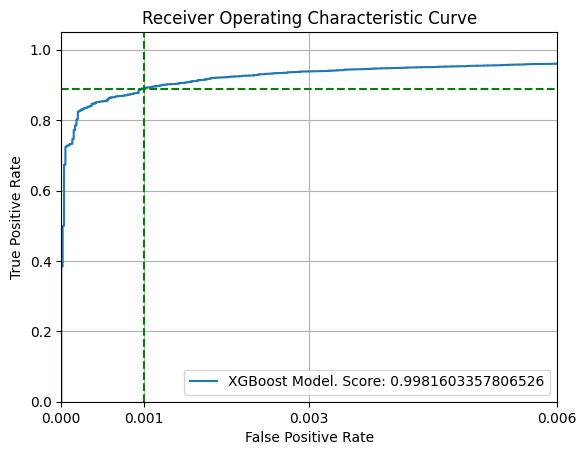

In [23]:
evaluating_new_data(model_1, X_adjusted_val, y_adjusted_val)

In [22]:
evaluate_new_data_performane_on_pca(model_2, pca, X_adjusted_val, y_adjusted_val)

NameError: ignored

2

In [24]:
X_adjusted_val, y_adjusted_val = separate_val_data(X_val, y_val, malicious_proportion=0.1)

#samples: 65936
#benign: 59929
#malicious: 6007
proportion: 0.091


The threshold that corresponds to FPR=0.001 is 0.980


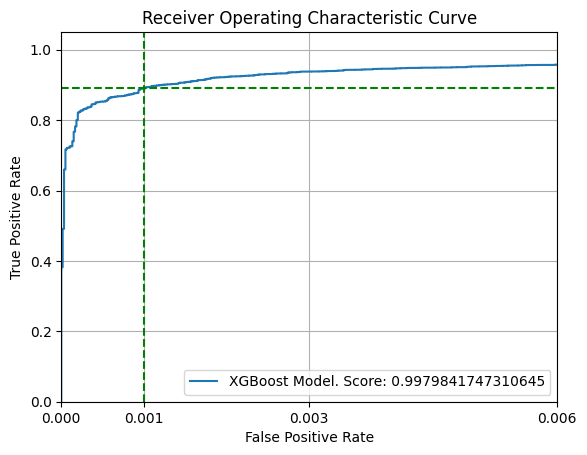

In [25]:
evaluating_new_data(model_1, X_adjusted_val, y_adjusted_val)

In [ ]:
evaluate_new_data_performane_on_pca(model_2, pca, X_adjusted_val, y_adjusted_val)

results:

Accuracy:  0.8683875272991992
False Positive Rate (FPR):  0.14019923576231874
True Positive Rate (TPR):  0.9540536041285167


## **Model Selection**

More comparison methods



## Response time on validation set - Model 1 vs Model 2

In [27]:
X_train = np.load(f'{gdrive_data_folder}/X_train.npy')
y_train = np.load(f'{gdrive_data_folder}/y_train.npy')
X_val = np.load(f'{gdrive_data_folder}/X_val.npy')
y_val = np.load(f'{gdrive_data_folder}/y_val.npy')

KeyboardInterrupt: ignored

The threshold that corresponds to FPR=0.001 is 0.980


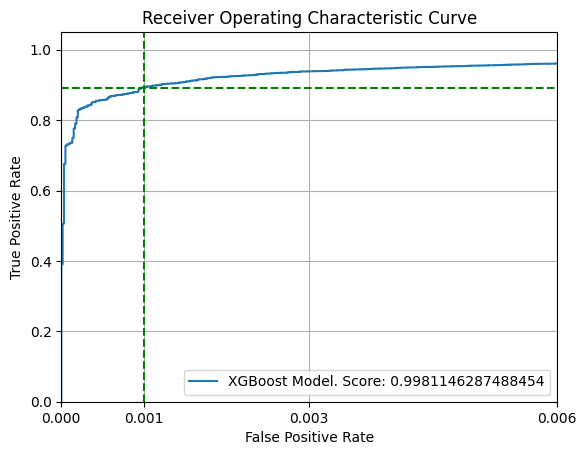

In [28]:
start_time = time.time()
# Evaluate performance
evaluating_new_data(model_1, X_val, y_val)
end_time = time.time()
model_1_execution_time = end_time - start_time

In [29]:
start_time = time.time()
# Evaluate performance
_, _ = evaluate_new_data_performane_on_pca(model_2, pca, X_val, y_val)
end_time = time.time()
model_2_execution_time = end_time - start_time

NameError: ignored

In [30]:
print(f"MODEL 1 Execution time: {model_1_execution_time:.3f} seconds")
print(f"MODEL 2 Execution time: {model_2_execution_time:.3f} seconds")

MODEL 1 Execution time: 2.193 seconds


NameError: ignored

## **PDS**

First, we will create our Probabilistic Data Structure that mapping th SHA256 codes to mlicious or binain such that: \
1. Each Malicious file is mapped as mlicious. \
    **FNR(False Negative Rate)=0**
2. The number of binain files that are mapped as malicious is less than 0.01% from the number of all files. \
    **FPR(False Positive Rate)<=0.01%**

#### **Bloom Filter**

We are using the Bloom FIlter Data Structure for checking the exsiting of a malicious file in efficiet way. 

A Bloom filter is a probabilistic data structure that is used to efficiently test whether an element is a member of a set. It uses a bit array and a set of hash functions to represent the set of elements and to determine whether an element is likely to be a member of the set.

Bloom filters have several advantages over other data structures such as hash tables or binary search trees. \
- They are very space-efficient, requiring only a small amount of memory to store the bit array and hash functions.\
- They are very fast, with constant-time insertions and lookups. 
- They can handle large sets of elements with a low probability of false positives.

Bloom filters are particularly useful in cases where the cost of false positives is low (i.e., it is acceptable to occasionally say that a file is a malicous while is not), but the cost of false negatives is high (i.e., it is not acceptable to miss a malicous file).

In [ ]:
class BloomFilter:
    def __init__(self, n, fpr):
        """
        Inputs:
         n - number of elements that might be inserted to the bloom filter
         fpr - the required False Positive Rate
        """
        bitarry_size, hash_count = self.find_optimal_size(n, fpr)
        self.n = n
        self.size = bitarry_size
        self.hash_count = hash_count
        self.bitarray = bitarray.bitarray(bitarry_size)
        self.bitarray.setall(0)

    def add(self, item):
        for i in range(self.hash_count):
            digest = hashlib.sha256(str(item).encode('utf-8') + str(i).encode('utf-8')).hexdigest()
            index = int(digest, 16) % self.size
            self.bitarray[index] = 1

    def __contains__(self, item):
        for i in range(self.hash_count):
            digest = hashlib.sha256(str(item).encode('utf-8') + str(i).encode('utf-8')).hexdigest()
            index = int(digest, 16) % self.size
            if not self.bitarray[index]:
                return False
        return True

    def get_size(self):
      return self.size

    def get_hash_count(self):
      return self.hash_count

    def find_optimal_size(self, n, fpr):
        """
        The find_optimal_size function compute the optimal size of a bit-array 
        and the number of hash functions needed for a Bloom filter that will store n items with a desired false positive rate of fpr.
        """
        bitarray_size = int(-1 * ((n * np.log(fpr)) / np.log(2) ** 2)) + 1
        number_of_hash_functions = int((bitarray_size / n) * math.log(2))
        return bitarray_size, number_of_hash_functions

    def __str__(self):
      return f"Bloom filter size: {self.size} \nFalse Positive Rate: {(1 - math.exp(-self.hash_count * self.n/ self.size)) ** self.hash_count} \nNumber of Hash functions: {self.hash_count}"

## Malicous SHA256 for EMBER

Read the SHA256 from the 'task1_malicious_sha256_ember.txt' and insert to our bloom filter.

In [ ]:
fpr = 0.0001
with open(file_path_to_malicous_sha256_ember, 'r') as f:
    n = sum(1 for line in f) 
    bloom_filter = BloomFilter(n, fpr)
    for hash_code_line in f:
        bloom_filter.add(hash_code_line)
    print(bloom_filter)       

## Expirement

In [ ]:
"""

I need to save aboce the removed features ( to remove them from new entities)

I need to save the weights from the pca as a vecto

I need to verify that a new entity (in the real world has all the features otherwise we need to handle it somehow)

THEM multiply the clean new instance with the pca weights vector and predict by xgb

-- if malicous then decalre as malicous
-- if benign then go to the bloom filter with sha256

"""

'\n\nI need to save aboce the removed features ( to remove them from new entities)\n\nI need to save the weights from the pca as a vecto\n\nI need to verify that a new entity (in the real world has all the features otherwise we need to handle it somehow)\n\nTHEM \n'

In [ ]:
"""Transforming the data using the principal component analysis (PCA) approach may add a small computational overhead to the inference pipeline, but this is generally negligible, especially when compared to the time saved due to the reduction in dimensionality."""